In [1]:
#!pip install geopy
#!pip install python-google-places
%matplotlib inline
import pandas as pd
from datetime import datetime
from geopy.distance import geodesic
import geopy.distance
from geopy.distance import vincenty as VIN
from geopy.distance import great_circle
from googleplaces import GooglePlaces, types, lang
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pylab as plot
from sklearn.linear_model import LinearRegression
from sklearn import datasets

data = pd.read_csv(r"C:\Users\Khaled\Google Drive\Self Development\University of Toronto Data Science Certificate\3250 Foundations of Data Science\Term Project\unique_mls_db_GIT.csv")
cpi=pd.read_csv(r"C:\Users\Khaled\Google Drive\Self Development\University of Toronto Data Science Certificate\3250 Foundations of Data Science\Term Project\CPI.csv")

#coordinates of major go train stations in mississauga and nearby cities: Lisgar, Meadowvale, Streesville, _
#Erindale, Cocksville, Dixie, Kipling, Clarkson, Port Credit, and Long Branch

go_station_msga=[[43.5905809,-79.788362],[43.5976,-79.75369999999998],
                 [43.5762,-79.70910000000003],[43.5670973,-79.6689102],
                 [43.5819,-79.62369999999998],[43.607605,-79.5776749],
                 [43.6357039,-79.5372283],[43.51251816552179,-79.63435649871826],
                 [43.5555,-79.5874],[43.59133291164543,-79.54609036445617]]

#coordinates of major hospitals in mississauga

hospitals_msga = [[43.5713, -79.6084],[43.5594, -79.7033],[43.4507, -79.7639],[43.5733, -79.6097]]


In [2]:
data.head()

,mlsno,stno,stname,city,area,soldprice,solddate,type,style,bdrm,wshrm,latitude,longitude,house_condo,aptno,address
0,E3853125,46,Hinsley,Ajax,Northeast Ajax,595000,6/30/2017,Semi-Detached,2-Storey,3,3,43.891599,-79.028612,house,NaN,"46 Hinsley Cres, Ajax"
1,E3833751,508,Norfolk,Pickering,Amberlea,677000,6/30/2017,Detached,2-Storey,3,3,43.827530,-79.123617,house,NaN,"508 Norfolk Sq, Pickering"
2,N3788507,36,Innisvale,Markham,Cornell,725000,6/30/2017,Semi-Detached,2-Storey,4,3,43.900148,-79.238976,house,NaN,"36 Innisvale Dr, Markham"
3,E3855735,14,Shudell,Toronto E01,Blake-Jones,755000,6/30/2017,Semi-Detached,2-Storey,2,2,43.675379,-79.337634,house,NaN,"14 Shudell Ave, Toronto"
4,W3854388,2500,Hargood,Mississauga,Streetsville,1050000,6/30/2017,Detached,2-Storey,4,3,43.576264,-79.729552,house,NaN,"2500 Hargood Pl, Mississauga"


In [3]:
data.describe()

,soldprice,bdrm,wshrm,latitude,longitude
count,1.955240e+05,195524.000000,195524.000000,195524.000000,195524.000000
mean,7.656679e+05,2.830855,2.653142,43.727473,-79.468918
std,5.719666e+05,1.097000,1.238492,0.136501,0.233164
min,0.000000e+00,0.000000,0.000000,43.288120,-80.127424
25%,4.390000e+05,2.000000,2.000000,43.642452,-79.650354
50%,6.310000e+05,3.000000,2.000000,43.721190,-79.446030
75%,8.880000e+05,4.000000,3.000000,43.822972,-79.345323
max,2.588889e+07,9.000000,35.000000,44.155510,-78.687984


In [4]:
data_msga = data.loc[data['city']=='Mississauga']
data_msga.head()

,mlsno,stno,stname,city,area,soldprice,solddate,type,style,bdrm,wshrm,latitude,longitude,house_condo,aptno,address
4,W3854388,2500,Hargood,Mississauga,Streetsville,1050000,6/30/2017,Detached,2-Storey,4,3,43.576264,-79.729552,house,NaN,"2500 Hargood Pl, Mississauga"
38,W3817888,551,Cavell,Mississauga,Cooksville,668000,6/29/2017,Semi-Detached,Bungalow-Raised,3,2,43.563612,-79.622475,house,NaN,"551 Cavell Dr, Mississauga"
39,W3850685,3582,Birchmeadow,Mississauga,Applewood,670000,6/29/2017,Semi-Detached,Bungalow-Raised,3,2,43.612874,-79.607933,house,NaN,"3582 Birchmeadow Cres, Mississauga"
40,W3848786,4186,Uxbridge,Mississauga,Rathwood,804500,6/29/2017,Detached,2-Storey,3,3,43.616948,-79.613434,house,NaN,"4186 Uxbridge Lane, Mississauga"
42,W3835920,4597,Centretown,Mississauga,Hurontario,889500,6/29/2017,Semi-Detached,2-Storey,4,4,43.595464,-79.664838,house,NaN,"4597 Centretown Way, Mississauga"


In [5]:
def classifyHouseFees():
    
    global data_msga
    house_fees = {'house':1, 'condo':2}
    data_msga['house_fees'] = data_msga['house_condo'].map(house_fees)

In [6]:
def mapHouseArea():
    
    global data_msga
    house_area = {'Streetsville':1, 'Cooksville':2,'Applewood':3,'Rathwood':4,'Hurontario':5,'Central Erin Mills':6,'Mineola':7,'Clarkson':8,
                 'City Centre':9,'Meadowvale':10,'Malton':11,'Erin Mills':12,'Churchill Meadows':13,'Lisgar':14,'Port Credit':15,'East Credit':16,
                 'Creditview':17,'Meadowvale Village':18,'Lorne Park':19,'Fairview':20,'Mississauga Valleys':21,
                 'Erindale':22,'Sheridan':23,'Dixie':24,'Northeast':25,'Mavis-Erindale':26,'Gateway':27,
                 'Meadowvale Business Park':28,'Sheridan Park':29,'Southdown':30,'Port Credi':31,'City Centr':32,
                  'Lakeview':33,'Huttonville':34}    
    
    data_msga['house_area'] = data_msga['area'].map(house_area)

In [7]:
def adjustSoldPrice():
    
    global data_msga
    #add soldyear, soldmonth columns
    data_msga.loc[:,['solddate']] = pd.to_datetime(data_msga['solddate'])
    data_msga.insert(len(data_msga.columns),column='soldyear',value=pd.DatetimeIndex(data_msga['solddate']).year)
    data_msga.insert(len(data_msga.columns),column='soldmonth',value=pd.DatetimeIndex(data_msga['solddate']).month)

    #merge with CPI file and convert nominal sold prices to real sold prices with base case = 2015-07-31 

    cpi_targetrange=cpi[(pd.to_datetime(cpi['Date'])>=datetime(2015,7,1)) & (pd.to_datetime(cpi['Date'])<=datetime(2017,6,30))]
    cpi_targetrange.insert(len(cpi_targetrange.columns),column='soldyear',
                           value=pd.DatetimeIndex(cpi_targetrange['Date']).year)
    cpi_targetrange.insert(len(cpi_targetrange.columns),column='soldmonth',
                           value=pd.DatetimeIndex(cpi_targetrange['Date']).month)
    data_msga=pd.merge(cpi_targetrange, data_msga, on=['soldyear','soldmonth'], how='outer')
    cpibase=float(cpi_targetrange['PX_LAST'][pd.to_datetime(cpi_targetrange['Date'])==datetime(2015,7,31)])
    data_msga.insert(len(data_msga.columns),column='cpibase',value=cpibase)
    data_msga.insert(len(data_msga.columns),column='adjustedSoldPrice',value=
                    round(data_msga['soldprice']*data_msga['cpibase']/data_msga['PX_LAST'],0))

In [8]:
#take a house's coordinates and calculate minimum distance of a house to GO stations 
def closestGoHospital():
    global data_msga
    
    data_msga_coordinate = data_msga[['latitude','longitude']].values
    mindist_GO = []
    mindist_Hospital = []
    for i in range(len(data_msga_coordinate)):
        tempGO = []
        tempHospital = []
        for j in range(len(go_station_msga)):
            tempGO.append(geodesic(go_station_msga[j], data_msga_coordinate[i]).meters)
        mindist_GO.append(round(min(tempGO), 2))

        for j in range(len(hospitals_msga)):
            tempHospital.append(geodesic(hospitals_msga[j], data_msga_coordinate[i]).meters)
        mindist_Hospital.append(round(min(tempHospital),2))
        
    #add the minimum distance to the dataframe

    data_msga.insert(len(data_msga.columns),column='mindist_GO',value=mindist_GO)
    data_msga.insert(len(data_msga.columns),column='mindist_Hospital',value=mindist_Hospital)

In [9]:
def classifySeasons():
    
    global data_msga
    data_msga['season'] = ''
    #summer season is from April to August
    data_msga.loc[(data_msga.soldmonth<=8 ) & (data_msga.soldmonth >=4),'season']= '1'
    
    #shoulder season from September to November
    data_msga.loc[(data_msga.soldmonth<=11 ) & (data_msga.soldmonth >=9),'season']= '2'
    
    #winter season from December to March
    data_msga.loc[(data_msga.soldmonth==12 ) | (data_msga.soldmonth >=1) & (data_msga.soldmonth <=3),'season']= '3' 

In [10]:
classifyHouseFees()
mapHouseArea()    
adjustSoldPrice()
closestGoHospital()
classifySeasons()

C:\Users\Khaled\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Khaled\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Khaled\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [11]:
#clean unwanted coloumns
data_msga.drop(['latitude','longitude','Date','area','soldyear','house_condo','soldmonth','city','stno','stname','PX_LAST','style','cpibase','aptno','mlsno','type','address','solddate','soldprice'], axis=1,inplace = True)

In [12]:
data_msga

,bdrm,wshrm,house_fees,house_area,adjustedSoldPrice,mindist_GO,mindist_Hospital,season
0,4,3,1,1,1025038.0,1652.02,2829.88,1
1,3,2,1,2,652120.0,2034.26,1422.18,1
2,3,2,1,3,654072.0,2511.87,4399.19,1
3,3,3,1,4,785375.0,3067.71,4858.85,1
4,4,4,1,5,868354.0,3168.72,5070.10,1
5,4,4,1,5,883485.0,4212.47,5828.68,1
6,4,3,1,6,1034801.0,677.66,1925.86,1
7,4,4,1,5,1029919.0,4364.62,5775.82,1
8,2,2,1,7,1054325.0,1844.45,2615.11,1
9,4,4,1,6,1425291.0,1677.39,1001.50,1


In [13]:
#Check if any value in the dataframe is Null
data_msga.isnull().values.any()

False

In [15]:
#plt.plot(data_msga['Date'],data_msga['adjustedSoldPrice'],color='r')

#sns.set_palette("GnBu_d")
#sns.set_style('whitegrid')

#sns.jointplot(x=data_msga['mindist_Hospital'],y=data_msga['adjustedSoldPrice'],data=data_msga)
#sns.jointplot(x=data_msga['mindist_Hospital'],y=data_msga['adjustedSoldPrice'],kind="hex",data=data_msga)

In [ ]:
#sns.pairplot(data=data_msga,x_vars=data_msga['mindist_Hospital'],y_vars=data_msga['adjustedSoldPrice'])

[-6.05500696e+00 -9.03271202e+00  2.81504751e+04  4.27615894e+03
 -9.73384181e+04  9.80094978e+04  1.66072373e+05]


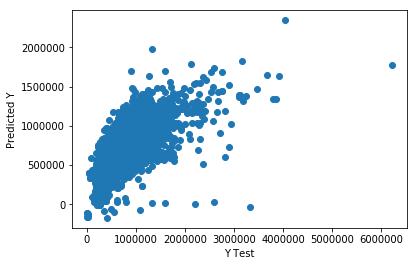

MAE :   172485.7337375471
MSE :   70275278202.79688
RMAE :   265094.84755988163


C:\Users\Khaled\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


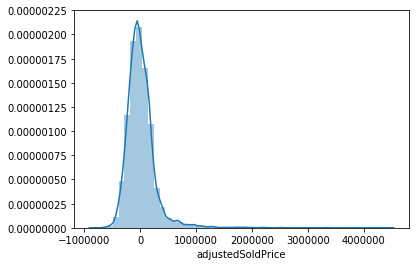

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X = data_msga[['mindist_GO','mindist_Hospital','season','house_area','house_fees','bdrm','wshrm']]

y = data_msga['adjustedSoldPrice']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#Create an instance of a LinearRegression() model named lm.
lm = LinearRegression(fit_intercept=False)

#Train/fit lm on the training data.
lm.fit(X_train,y_train)

#Print out the coefficients of the model
print(lm.coef_)

#evaluating performance by predicting off the test values
predictions = lm.predict(X_test)

#scatterplot of the real test values versus the predicted values
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()


#evaluate our model performance by calculating the residual sum of squares and the explained variance score (R^2)
print('MAE :'," ", metrics.mean_absolute_error(y_test,predictions))
print('MSE :'," ", metrics.mean_squared_error(y_test,predictions))
print('RMAE :'," ", np.sqrt(metrics.mean_squared_error(y_test,predictions)))


# explore the residuals to make sure everything was okay with our data.
#Plot a histogram of the residuals and make sure it looks normally distributed. Use either seaborn distplot, or just plt.hist().

sns.distplot(y_test - predictions,bins=50)

